In [ ]:
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
## reading and storing data
IMG_WIDTH=128
IMG_HEIGHT=128
NO_CHANNELS=3

train_path = '/content/drive/MyDrive/Colab Notebooks/Graduation Project/data'
# test_path = 'testing/'
# sample_size=50
images_path= 'image_2/'
labels_path = 'semantic_rgb/'

train_ids = os.listdir(os.path.join(train_path,images_path))

X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,NO_CHANNELS),dtype='uint8')
Y_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,NO_CHANNELS),dtype='uint8')


In [ ]:
for idx,i in enumerate(train_ids):
    path = os.path.join(train_path,images_path,i)
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    X_train[idx]= img

    path = os.path.join(train_path,labels_path,i)
    label = cv2.imread(path)
    label = cv2.cvtColor((label).astype(np.uint8), cv2.COLOR_BGR2RGB)
    label = cv2.resize(label,(IMG_WIDTH,IMG_HEIGHT))

    Y_train[idx]=label


In [ ]:
classes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Graduation Project/data/classes.csv',index_col='Unnamed: 0')
classes = classes[4:]
classes.head()
# len(classes)

,0,1,2
static,0,0,0
dynamic,111,74,0
ground,81,0,81
road,128,64,128
sidewalk,244,35,232


In [ ]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}
def adjust_mask(mask, flat=False):
    
    semantic_map = []
    for colour in list(cls2rgb.values()): 
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.
    if flat:
      semantic_map = np.reshape(semantic_map, (-1,128*128))

    return np.float16(semantic_map)# convert to numbers


In [ ]:
sample_y_converted = np.zeros((len(Y_train),Y_train[0].shape[0],Y_train[0].shape[1],len(classes)))
for i in range(0,Y_train.shape[0]):
    sample_y_converted[i] = adjust_mask(Y_train[i])

In [ ]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
def map_class_to_rgb(p): 
  return idx2rgb[p[0]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, sample_y_converted, 
                                                      test_size=0.1, shuffle=True, random_state=42)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size=0.1, shuffle=True, random_state=42)

In [ ]:
gen = ImageDataGenerator(
                    # rotation_range=0.2,
                    # width_shift_range=0.1,
                    # height_shift_range=0.1, 
                    # zoom_range=0.05,
                    # horizontal_flip=True,
                    # fill_mode='nearest',
                    rescale = 1./255
                        )
train_gen = gen.flow(X_train, y_train, batch_size=8)
valgen = ImageDataGenerator(
    rescale = 1./255
    )

val_gen = valgen.flow(X_valid, y_valid, batch_size=8)

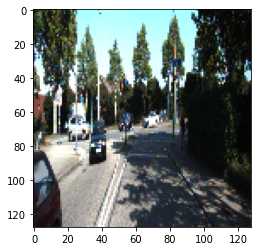

In [ ]:
plt.imshow(X_train[5])

In [ ]:
from keras import backend as K
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,NO_CHANNELS))

# s = tf.keras.layers.Lambda(Lambda x : x/255)(inputs)
s=inputs
## 1st block
c1 = tf.keras.layers.Conv2D(32,(3,3),activation='relu'
                            ,kernel_initializer='he_normal'
                            ,padding='same')(s)

# c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(32,(3,3),activation='relu'
                            ,kernel_initializer='he_normal'
                            ,padding='same')(c1)

p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

## 2nd bloc
c2 = tf.keras.layers.Conv2D(64,(3,3),activation='relu'
                            ,kernel_initializer='he_normal'
                            ,padding='same')(p1)
# c2 = tf.keras.layers.Dropout(0.1)(c2)

c2 = tf.keras.layers.Conv2D(64,(3,3),activation='relu'
                            ,kernel_initializer='he_normal'
                            ,padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

## 3rd block
c3 = tf.keras.layers.Conv2D(128,(3,3),activation='relu'
                            ,kernel_initializer='he_normal'
                            ,padding='same')(p2)
# c3 = tf.keras.layers.Dropout(0.1)(c3)

c3 = tf.keras.layers.Conv2D(128,(3,3),activation='relu'
                            ,kernel_initializer='he_normal'
                            ,padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

## 4th block

c4 = tf.keras.layers.Conv2D(256,(3,3),activation='relu'
                            ,kernel_initializer='he_normal'
                            ,padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)

c4 = tf.keras.layers.Conv2D(256,(3,3),activation='relu'
                            ,kernel_initializer='he_normal'
                            ,padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


## u-base block

c5 = tf.keras.layers.Conv2D(512,(3,3),activation='relu'
                            ,kernel_initializer='he_normal'
                            ,padding='same')(p4)
# c5 = tf.keras.layers.Dropout(0.3)(c5)

c5 = tf.keras.layers.Conv2D(512,(3,3),activation='relu'
                            ,kernel_initializer='he_normal'
                            ,padding='same')(c5)

########### expansion bloc (decoder)

## 6th block
u6 = tf.keras.layers.Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(256,(3,3),
                           activation='relu',
                           kernel_initializer='he_normal',
                           padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256,(3,3),
                           activation='relu',
                           kernel_initializer='he_normal',
                           padding='same')(c6)
## 7th block

u7 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(128,(3,3),
                           activation='relu',
                           kernel_initializer='he_normal',
                           padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128,(3,3),
                           activation='relu',
                           kernel_initializer='he_normal',
                           padding='same')(c7)

## 8th block
u8 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(64,(3,3),
                           activation='relu',
                           kernel_initializer='he_normal',
                           padding='same')(u8)
# c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64,(3,3),
                           activation='relu',
                           kernel_initializer='he_normal',
                           padding='same')(c8)


## 9th block
u9 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1],axis=3)
c9 = tf.keras.layers.Conv2D(32,(3,3),
                           activation='relu',
                           kernel_initializer='he_normal',
                           padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32,(3,3),
                           activation='relu',
                           kernel_initializer='he_normal',
                           padding='same')(c9)



##### outputs
outputs = tf.keras.layers.Conv2D(31,(1,1),activation='softmax')(c9)

model = tf.keras.models.Model(inputs=[inputs],outputs=[outputs])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=jaccard_distance, metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=31)])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=31)])

# model.summary()




In [ ]:
# model.fit(X_train,Y_train, validation_split=0.3,batch_size=32,epochs=5)
# model.compile(optimizer="adam", loss="categorical_crossentropy")
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('test.hdf5', monitor='loss',verbose=1, save_best_only=True)

history = model.fit(train_gen, steps_per_epoch=None, epochs=200,
                              validation_data=val_gen, validation_steps=None,
                    # callbacks=[model_checkpoint]
                    )
# X_train, X_valid, y_train, y_valid 
# history = model.fit(X_train,y_train, batch_size=8,epochs=50,
#                               validation_data=(X_valid,y_valid))

Epoch 1/200
21/21 [==============================] - 14s 412ms/step - loss: 1.6950 - accuracy: 0.1839 - mean_io_u: 0.5082 - val_loss: 1.4667 - val_accuracy: 0.2791 - val_mean_io_u: 0.5512
Epoch 2/200
21/21 [==============================] - 6s 309ms/step - loss: 1.4590 - accuracy: 0.2778 - mean_io_u: 0.5537 - val_loss: 1.3880 - val_accuracy: 0.3191 - val_mean_io_u: 0.5684
Epoch 3/200
21/21 [==============================] - 5s 243ms/step - loss: 1.3930 - accuracy: 0.3116 - mean_io_u: 0.5659 - val_loss: 1.2923 - val_accuracy: 0.3681 - val_mean_io_u: 0.5807
Epoch 4/200
21/21 [==============================] - 4s 212ms/step - loss: 1.3063 - accuracy: 0.3562 - mean_io_u: 0.5754 - val_loss: 1.2955 - val_accuracy: 0.3663 - val_mean_io_u: 0.5845
Epoch 5/200
21/21 [==============================] - 4s 197ms/step - loss: 1.2968 - accuracy: 0.3607 - mean_io_u: 0.5836 - val_loss: 1.2900 - val_accuracy: 0.3691 - val_mean_io_u: 0.5868
Epoch 6/200
21/21 [==============================] - 6s 299ms/st

In [ ]:
# preds = model.predict(X_train)
from keras.models import load_model
# model = load_model("test.hdf5")

preds = model.predict(X_test)
preds.shape

(20, 128, 128, 31)

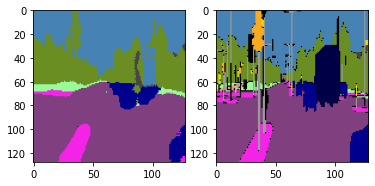

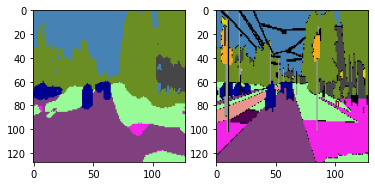

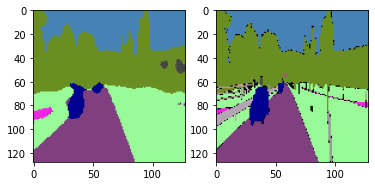

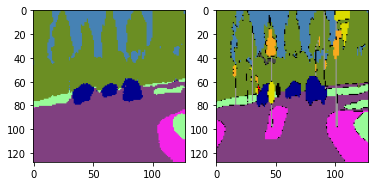

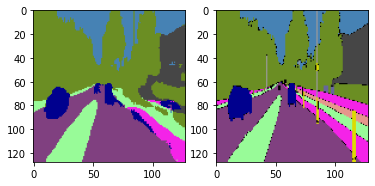

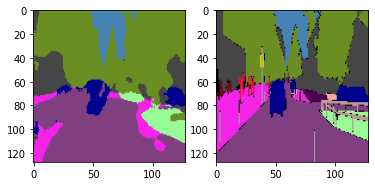

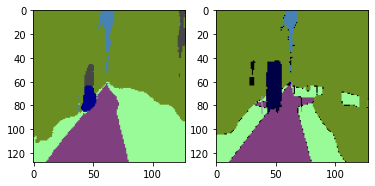

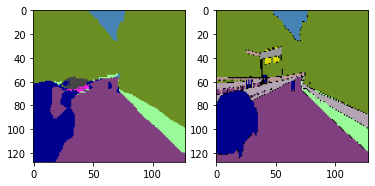

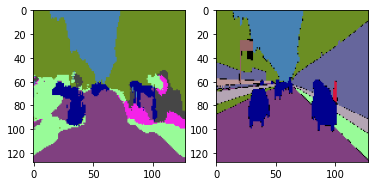

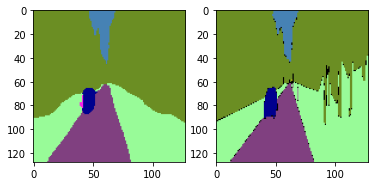

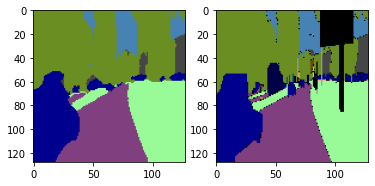

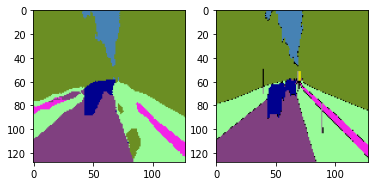

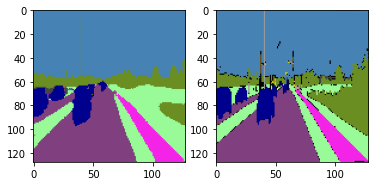

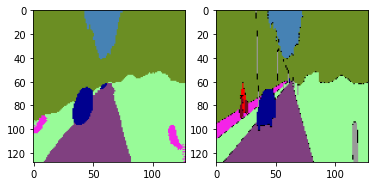

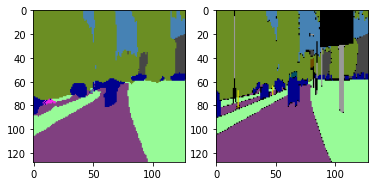

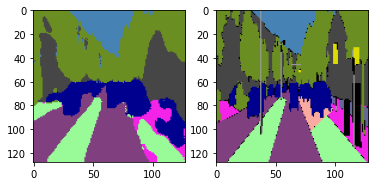

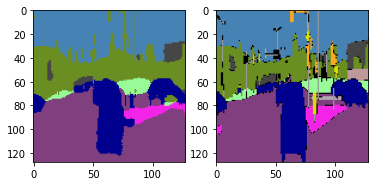

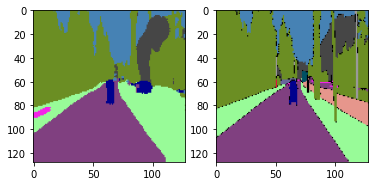

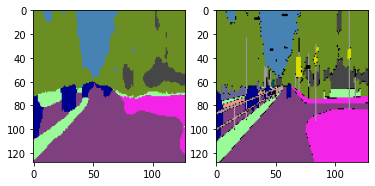

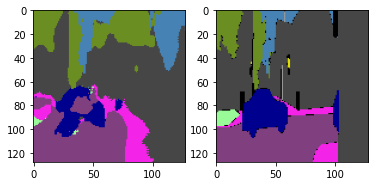

In [ ]:
for i in range(len(y_test)):
    fig , ax = plt.subplots(1,2)
    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(preds[i], axis=-1), -1))
    ax[0].imshow(rgb_mask)
    original = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(y_test[i], axis=-1), -1))
    ax[1].imshow(original)

In [ ]:
# !pip install segmentation_models

     |████████████████████████████████| 50 kB 3.6 MB/s 


In [ ]:
import segmentation_models as sm

sm.set_framework('tf.keras')
sm.framework()
# model = sm.Unet('resnet34', activation='sigmoid')

# model = sm.Unet('resnet50', encoder_weights='imagenet',activation='softmax' , classes=31 , encoder_freeze=True)
model = sm.Linknet('resnet50', encoder_weights='imagenet',activation='softmax' , classes=31 , encoder_freeze=True)


# N = X_train.shape[-1]

# base_model = sm.Unet(backbone_name='resnet50', encoder_weights='imagenet',activation=)

# inp = tf.keras.layers.Input(shape=(None, None, N))
# l1 = tf.keras.layers.Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
# out = base_model(l1)

# model = tf.keras.models.Model(inp, out, name=base_model.name)

model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit(
   x=X_train,
   y=y_train,
   batch_size=4,
   epochs=200,
   validation_data=(X_valid, y_valid),
)

Epoch 1/200
41/41 [==============================] - 25s 341ms/step - loss: 1.3241 - iou_score: 0.0187 - val_loss: 6.9926 - val_iou_score: 0.0084
Epoch 2/200
41/41 [==============================] - 7s 161ms/step - loss: 1.0596 - iou_score: 0.0497 - val_loss: 1.2547 - val_iou_score: 0.0203
Epoch 3/200
41/41 [==============================] - 7s 173ms/step - loss: 0.9991 - iou_score: 0.0803 - val_loss: 1.1258 - val_iou_score: 0.0409
Epoch 4/200
41/41 [==============================] - 10s 242ms/step - loss: 0.9685 - iou_score: 0.0990 - val_loss: 1.0853 - val_iou_score: 0.0601
Epoch 5/200
41/41 [==============================] - 8s 205ms/step - loss: 0.9528 - iou_score: 0.1082 - val_loss: 1.0758 - val_iou_score: 0.0395
Epoch 6/200
41/41 [==============================] - 7s 183ms/step - loss: 0.9432 - iou_score: 0.1142 - val_loss: 1.2507 - val_iou_score: 0.0543
Epoch 7/200
41/41 [==============================] - 7s 162ms/step - loss: 0.9306 - iou_score: 0.1230 - val_loss: 0.9898 - val_i

In [ ]:
preds = model.predict(X_test)
preds.shape


(20, 128, 128, 31)

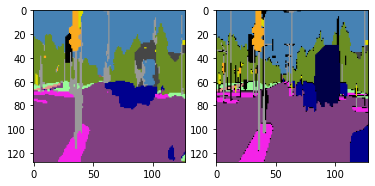

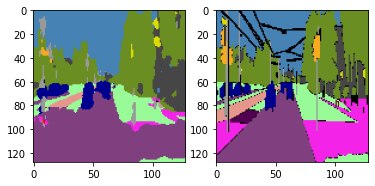

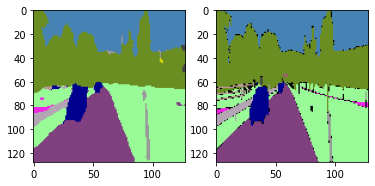

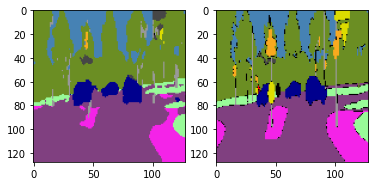

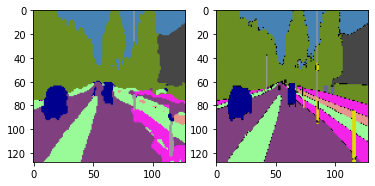

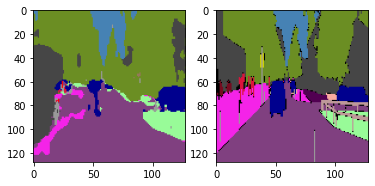

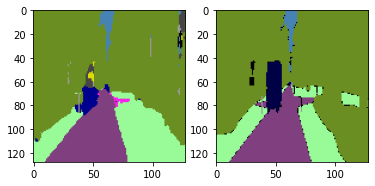

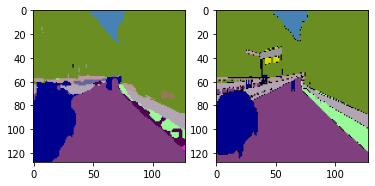

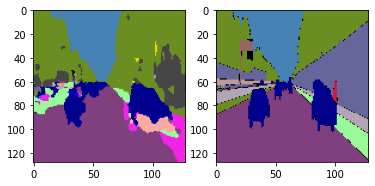

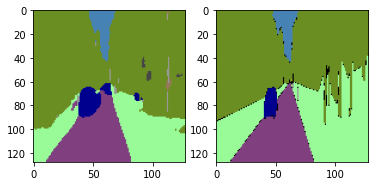

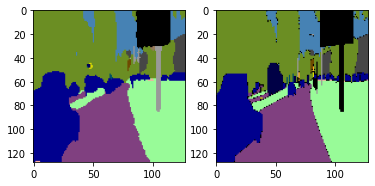

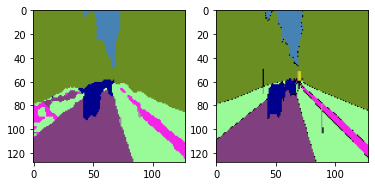

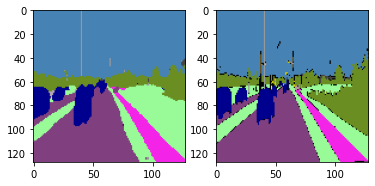

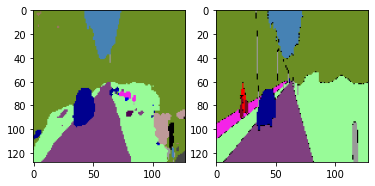

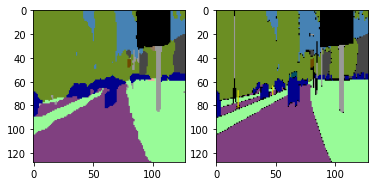

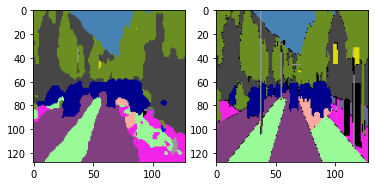

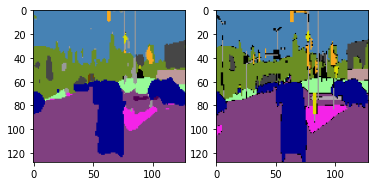

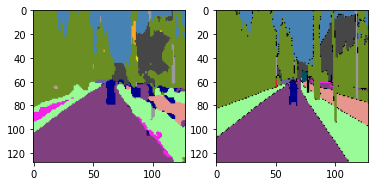

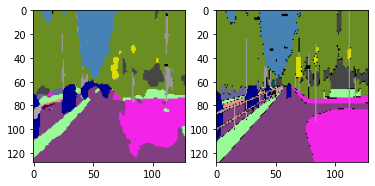

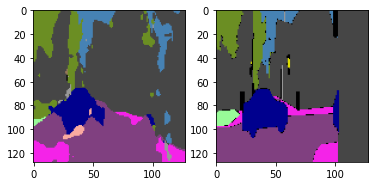

In [ ]:
for i in range(len(y_test)):
    fig , ax = plt.subplots(1,2)
    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(preds[i], axis=-1), -1))
    ax[0].imshow(rgb_mask)
    original = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(y_test[i], axis=-1), -1))
    ax[1].imshow(original)

In [ ]:
# !pip install keras-segmentation


In [ ]:
from keras_segmentation.models.unet import vgg_unet

model = vgg_unet(n_classes=31 ,  input_height=256, input_width=256  )

model.train(
    train_images =  os.path.join(train_path,images_path),
    train_annotations = os.path.join(train_path,labels_path),
    checkpoints_path = "/tmp/vgg_unet_1" , epochs=5
)

# out = model.predict_segmentation(
#     inp="dataset1/images_prepped_test/0016E5_07965.png",
#     out_fname="/tmp/out.png"
# )

# import matplotlib.pyplot as plt
# plt.imshow(out)

# # evaluating the model 
# print(model.evaluate_segmentation( inp_images_dir="dataset1/images_prepped_test/"  , annotations_dir="dataset1/annotations_prepped_test/" ) )

In [ ]:
import keras_segmentation